<a href="https://colab.research.google.com/github/duskvirkus/colab-notebooks/blob/main/MiniDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MiniDiffusion**

## The code base for this notebook is authored by Hannu Töyrylä @htoyryla (github handle: htoyryla) 

## Original code base:  https://github.com/lucidrains/denoising-diffusion-pytorch

## Notebook created by @PaulFishwick with help from Hannu.

Evolving code base: https://github.com/htoyryla/minidiffusion

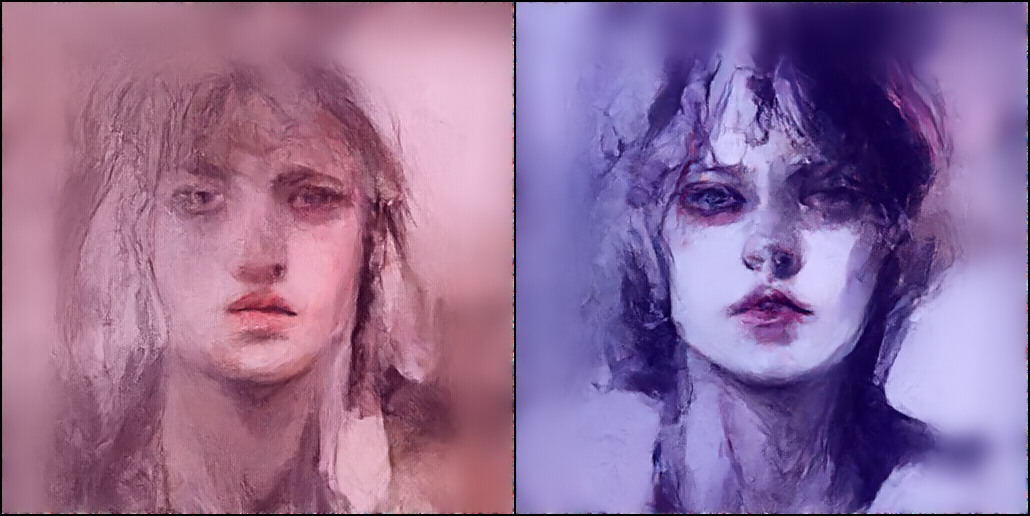

#If you interrupt this notebook at any time (e.g. Runtime->Interrupt Execution), make sure to Runtime->Restart Runtime

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-f4d4fb57-62fa-3633-97e1-2420f0d91b92)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install einops pytorch_msssim kornia
!pip install git+https://github.com/openai/CLIP.git
import os
path = "/content"
os.chdir(path)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 21.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kbiudgp1
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-kbiudgp1
     |████████████████████████████████| 53 kB 1.5 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=412dfc46306f6bfd4af4f7d8a04f4585c445cc3e182a92f388dd6e8316c7badf
  Stored in directory: /tmp/pip-ephem-wheel-cache-9d3iubkq/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
# this codebase changes rapidly so cloning master each time
# and cleaning directory hierarchy within Google Drive
#
# WARNING: make sure to save older outputdir *models* and *images*. Executing this cell will
# remove the minidiffusion directory, including outputdir and all sub-files.
#
pretrained_models = '/content/drive/MyDrive/pretrained'
installdir = '/content/drive/MyDrive/minidiffusion'
# output directory where produced images are stored
outputdir = '/content/drive/MyDrive/minidiffusion/output'
samplesdir = '/content/drive/MyDrive/minidiffusion/samples'
if os.path.isdir(installdir):
  !rm -rf {installdir}
!git clone https://github.com/htoyryla/minidiffusion {installdir}
if os.path.isdir(outputdir):
  !rm -rf {outputdir}
!mkdir {outputdir}
!mkdir {samplesdir}
%cd {installdir}

Cloning into '/content/drive/MyDrive/minidiffusion'...
remote: Enumerating objects: 455, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 455 (delta 47), reused 71 (delta 42), pack-reused 376
Receiving objects: 100% (455/455), 2.29 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (309/309), done.
/content/drive/MyDrive/minidiffusion


#Training

Models (--model): unetcn0, unet0, unet0k5, unet1. unet0 uses a 3x3 kernel, and unet0k5 uses a 5x5 kernel. 

Loss types are ssim, l0 and l1.

An incremental approach to training starting with a larger LR and progressing to a smaller LR is: 

1. python diffutrainer.py --images etch/  --accum 10 --saveEvery 100 --losstype l1 --nsamples 2 --batchSize 2 --imageSize 512 --mults 1 1 2 2 4 4 8 --dir un1etch --trainsteps 200000 --lr 4e-4 --model unet1 

2. python diffutrainer.py --images etch/  --accum 10 --saveEvery 100 --losstype l1 --nsamples 2 --batchSize 2 --imageSize 512 --mults 1 1 2 2 4 4 8 --dir un1etch2 --trainsteps 200000 --lr 8e-5 --model unet1 --load un1etch/model-16.pt 

3. python diffutrainer.py --images etch/  --accum 10 --saveEvery 100 --losstype l1 --nsamples 2 --batchSize 2 --imageSize 512 --mults 1 1 2 2 4 4 8 --dir un1etch3 --trainsteps 200000 --lr 2e-5 --model unet1 --load un1etch2/model-54.pt 



In [ ]:
# # run this for training from a set of images
!python diffutrainer.py --images /content/drive/MyDrive/datasets/painterly-faces-v2 --lr 4e-4 --steps 1000 --accum 10 --dir output --losstype ssim --imageSize 512 --batchSize 2 --saveEvery 500 --nsamples 2 --mults 1 1 2 2 4 4 8 --model unet0k5 --load {pretrained_models}/model-30.pt
#!python diffutrainer.py --images /content/drive/MyDrive/datasets/Strutt1024sq-1024 --lr 5e-5 --steps 1000 --accum 10 --dir output --losstype l1 --imageSize 512 --batchSize 2 --saveEvery 100 --nsamples 4 --mults 1 1 2 4 4 8 --model unet1
# Phase 1: 20 cycles @ 4e-4 LR
# !python diffutrainer.py --images /content/drive/MyDrive/Augmentor/out --lr 4e-4 --steps 1000 --accum 10 --dir output --imageSize 512 --batchSize 2 --saveEvery 100 --nsamples 4 --mults 1 1 2 2 4 4 8 8 --model unet1 --trainsteps 200000 --losstype ssim
# Phase 2: 20-52 cycles @ 4e-5 LR
# !python diffutrainer.py --images /content/drive/MyDrive/Augmentor/out --lr 1e-5 --steps 1000 --accum 10 --dir output --imageSize 512 --batchSize 2 --saveEvery 100 --nsamples 4 --mults 1 1 2 2 4 4 8 8 --model unet1 --load {pretrained_models}/model-45.pt --trainsteps 200000 --losstype ssim

Streaming output truncated to the last 5000 lines.
22561: 0.0069321393966674805
22562: 0.010631918907165527
22563: 0.015390872955322266
22564: 0.011181473731994629
22565: 0.01629471778869629
22566: 0.014590740203857422
22567: 0.009215354919433594
22568: 0.01126396656036377
22569: 0.014777898788452148
22570: 0.02125096321105957
22571: 0.0077114105224609375
22572: 0.025949954986572266
22573: 0.012887716293334961
22574: 0.014036297798156738
22575: 0.01329350471496582
22576: 0.017121076583862305
22577: 0.008485555648803711
22578: 0.009873151779174805
22579: 0.0074634552001953125
22580: 0.0069370269775390625
22581: 0.024674296379089355
22582: 0.00926220417022705
22583: 0.014156818389892578
22584: 0.018024206161499023
22585: 0.0060536861419677734
22586: 0.016777753829956055
22587: 0.014243125915527344
22588: 0.016582965850830078
22589: 0.015446662902832031
22590: 0.010368704795837402
22591: 0.02213907241821289
22592: 0.015731334686279297
22593: 0.012033820152282715
22594: 0.01299750804901123

#Basic Sampling: the "epoch" option is used as follows:

Let's say the trained model is model-6.pt. Then you specify "model" when you use --load and set the epoch value to 6. This will get to the right model. More on epochs: 

Use:

--load {pretrained_models}/Diffusion-Model --epoch 55

and with

--load {pretrained_models}/Diffusion-Model --epoch 55 --epoch2 65 --estep

you can sample from Diffusion-Model-55.pt to Diffusion-Model-65.pt

with a single command.

In [ ]:
!python diffusampler.py --dir samples --name face --ema --modelSize 512 --mults 1 1 2 2 4 4 8 --nsamples 24 --batchSize 2 --load {pretrained_models}/Diffusion-Model --model unet0k5 --epoch 55 

loaded /content/drive/MyDrive/pretrained/Diffusion-Model-55.pt, correct mults: 1,1,2,2,4,4,8
sampling loop time step: 100% 1000/1000 [01:57<00:00,  8.53it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]
sampling loop time step: 100% 1000/1000 [01:56<00:00,  8.57it/s]


#Sampling with CLIP-Based Optimization

When we use CLIP to guide how the image evolves, we need arrange the image into a sequence of 244x244px pieces. This is usually done by making random crops which are resized into 244x244. There are many approaches how exactly to do that, here you can give

--low minimum size of crop, relative to the image width or height, respectively, usually 0.1 ... 0.7
--high maximum size of crop
--cutn number of crops

Something like --low -0.7 --high 1 --cutn 8 gives CLIP a good idea about the structure of the image while not ideal as to details, while --low 0.1 --high 0.15 --cutn 96 will tend to populate the image with small things.

In [ ]:
%cd {installdir}

In [ ]:
# play with the learning rate (lr). Using the default rate of 0.0004 may not provide the right image that matches
# the text prompt. Other possible values are increasing learning rate: 0.001, 0.002, 0.005, or 0.01
prompt = "A flower vase"
# prompt = "An abstract painting of a man playing a lute"
#!python diffudiver.py --text "{prompt}" --low 0.4 --high 0.8 --cutn 16 --dir {outputdir} --name 'test' --tgt_image /content/drive/MyDrive/datasets/Strutt1024sq-1024/the-chandos-oak.png --textw 0.95 --ssimw 0.10 --lr 0.002 --imageSize 1024 --modelSize 512 --load /content/drive/MyDrive/pretrained/minidiffusion-pretrained-6layers-512px/model-1351.pt --mults 1 1 2 4 4 8 --ema --saveEvery 50 --saveAfter 700  --model  unet1
#!python diffudiver.py --text "{prompt}" --low 0.4 --high 0.8 --cutn 16 --dir {outputdir} --name 'test' --tgt_image /content/drive/MyDrive/datasets/Strutt1024sq-1024/the-chandos-oak.png --textw 0.95 --ssimw 0.10 --lr 0.002 --imageSize 1024 --modelSize 512 --load {pretrained_models}/model-319.pt --mults 1 1 2 4 4 8 --ema --saveEvery 50 --saveAfter 700  --model  unet1
#for i in range(0,12):
# sample from the trained model with further optimization (e.g. CLIP via the text prompt)
!python diffudiver.py --steps 1000 --text "{prompt}" --low 0.4 --high 0.8 --cutn 16 --dir {outputdir} --name 'vase' --textw 0.5 --ssimw 0.5 --lr 0.002 --imageSize 1024 --modelSize 512 --load {pretrained_models}/Diffusion-Model-55.pt --mults 1 1 2 2 4 4 8 --ema --saveEvery 50 --saveAfter 700  --model unet0k5
# sample from the trained network without any further optimization - this is the fastest
# !python diffudiver.py --dir {outputdir} --textw 0 --ssimw 0 --imgpw 0 --lr 0.0 --name 'faces' --imageSize 512 --modelSize 512 --load {pretrained_models}/Diffusion-Model-55.pt --mults 1 1 2 2 4 4 8 --saveEvery 100 --saveAfter 700 --model unet0k5

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 259MiB/s]
loaded /content/drive/MyDrive/pretrained/Diffusion-Model-55.pt, correct mults: 1,1,2,2,4,4,8
sampling loop time step:   0% 0/1000 [00:00<?, ?it/s]Text loss:3.888671875 
sampling loop time step:   5% 50/1000 [00:16<05:11,  3.05it/s]Text loss:3.888671875 
sampling loop time step:  10% 100/1000 [00:33<04:54,  3.05it/s]Text loss:3.8828125 
sampling loop time step:  15% 150/1000 [00:49<04:38,  3.06it/s]Text loss:3.869140625 
sampling loop time step:  20% 200/1000 [01:05<04:22,  3.05it/s]Text loss:3.865234375 
sampling loop time step:  25% 250/1000 [01:22<04:05,  3.05it/s]Text loss:3.875 
sampling loop time step:  30% 300/1000 [01:38<03:48,  3.06it/s]Text loss:3.8671875 
sampling loop time step:  35% 350/1000 [01:54<03:32,  3.06it/s]Text loss:3.83203125 
sampling loop time step:  40% 400/1000 [02:11<03:16,  3.05it/s]Text loss:3.7734375 
sampling loop time step:  45% 450/1000 [02:27<03:00,  3.06it/s]Text loss:3.6